# Scikit-image testbench for image classification

## First steps: import and show an image with scikit-image


In [280]:
%matplotlib inline


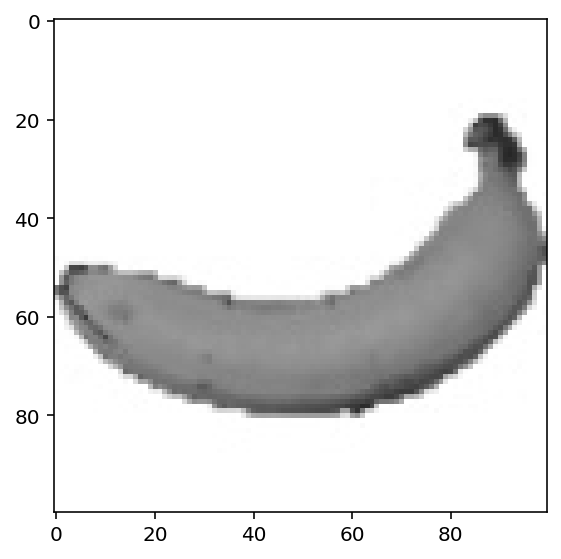

In [281]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# path to fruit360 dataset
path = '/home/gino/Desktop/fruits-360_dataset/'

def img_grayscale(image):
    return io.imread(image, as_gray=True)

banana_collection = io.ImageCollection(path + 'fruits-360/Training/Banana/*.jpg', load_func=img_grayscale)

io.imshow(banana_collection[180])
#print(banana_collection)

## Filtering

In [282]:
from skimage import filters

sample_banana = banana_collection[180]


### Gaussian filter

(100, 100)
float64


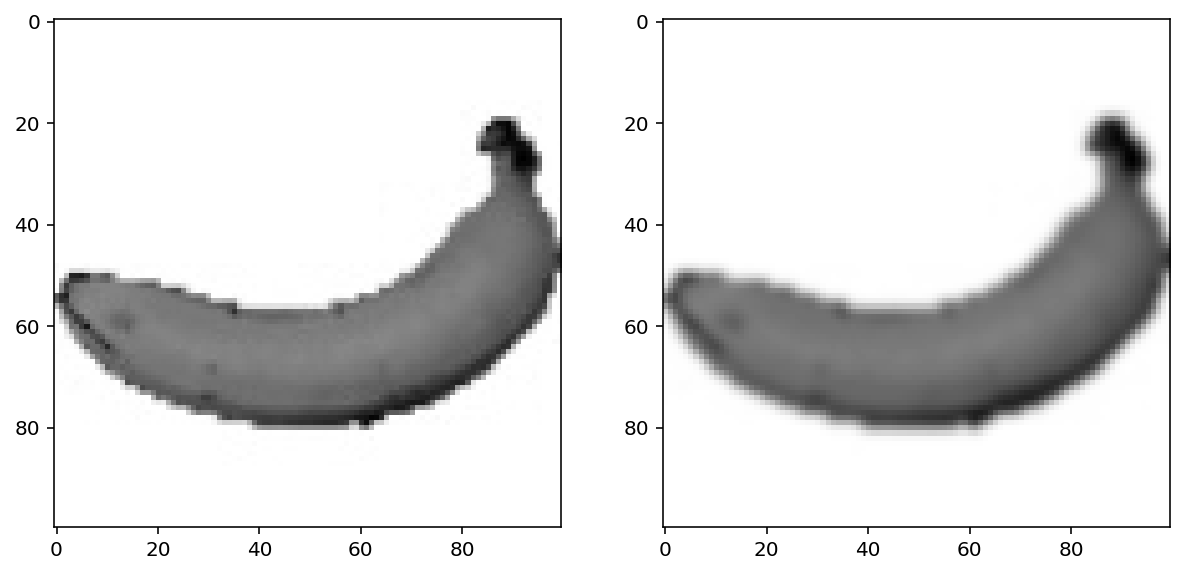

In [283]:

gauss_filtered = filters.gaussian(sample_banana, sigma=1)

print(gauss_filtered.shape)
print(sample_banana.dtype)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(sample_banana, cmap='gray')
ax[1].imshow(gauss_filtered, cmap='gray')

fig.set_size_inches(10, 10)

### Edge detection: Sobel and Scharr filters

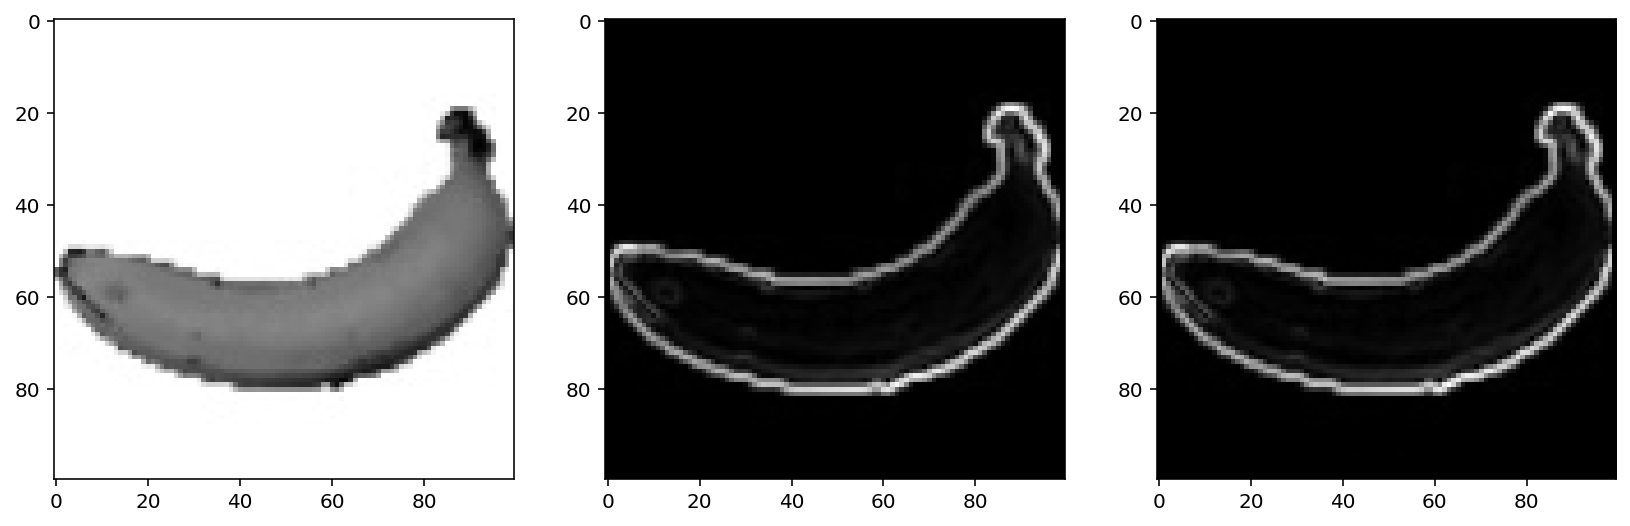

In [284]:
sobel_filtered = filters.sobel(sample_banana)

#plt.imshow(sample_banana, cmap='gray')

scharr_filtered = filters.scharr(sample_banana)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(sample_banana, cmap='gray')
ax[1].imshow(sobel_filtered, cmap='gray')
ax[2].imshow(scharr_filtered, cmap='gray')


fig.set_size_inches(14, 14)

#plt.imshow(scharr_filtered - sobel_filtered, cmap='gray')

### More edge detection: Canny filter

The Canny filter is a multi-stage edge detector. It uses a filter based on the derivative of a Gaussian in order to compute the intensity of the gradients.The Gaussian reduces the effect of noise present in the image. Then, potential edges are thinned down to 1-pixel curves by removing non-maximum pixels of the gradient magnitude. Finally, edge pixels are kept or removed using hysteresis thresholding on the gradient magnitude.

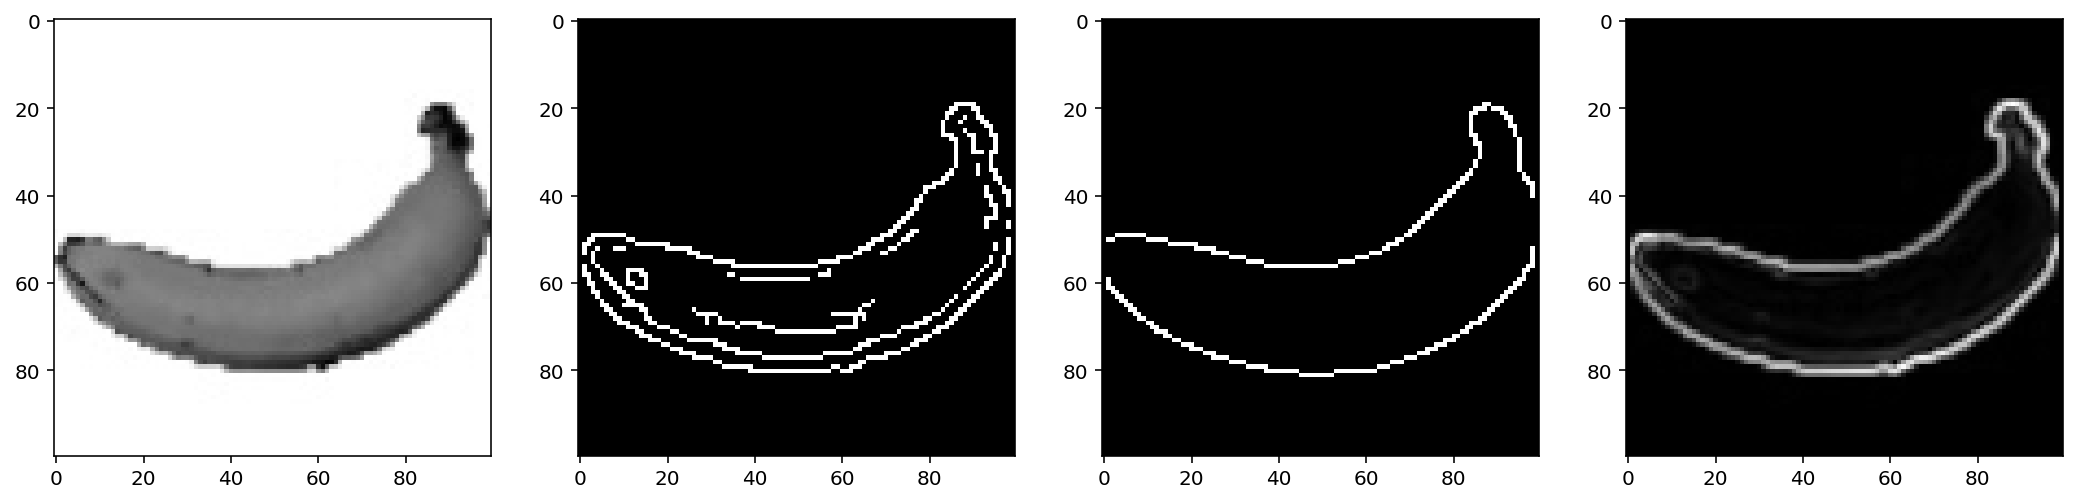

In [285]:
from skimage import feature
import matplotlib.pyplot as plt

canny_filtered_lowsigma = feature.canny(sample_banana, sigma=.5)
canny_filtered_hisigma = feature.canny(sample_banana, sigma=3)


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

ax[0].imshow(sample_banana, cmap='gray')
ax[1].imshow(canny_filtered_lowsigma, cmap='gray')
ax[2].imshow(canny_filtered_hisigma, cmap='gray')
#ax[3].imshow(canny_filtered_pregaussian, cmap='gray')
ax[3].imshow(sobel_filtered, cmap='gray')

### Thresholding

Many techniques exist but given the quality of the dataset we will not require any fancy thresholding algorithms or methods as hystheresis thresholing. The latter is used in the Canny edge-detection filter.  

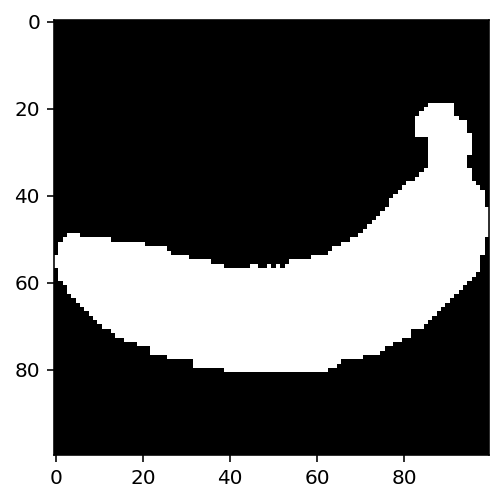

In [291]:
# Threshold value. Can be obtained algorithmically
threshold = .9

image = sample_banana > threshold

image = 1 - image

plt.imshow(image, cmap='gray')

### Trying all thresholding methods

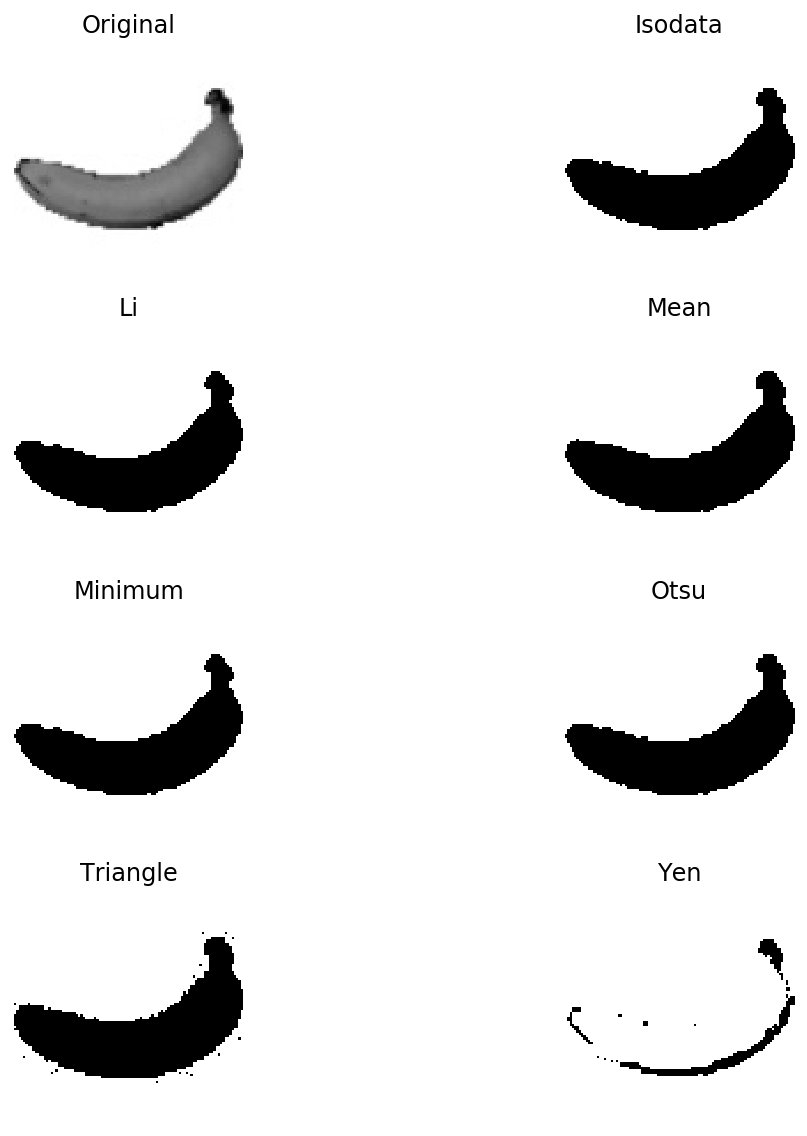

In [304]:
fig, ax = filters.try_all_threshold(sample_banana, figsize=(10, 8), verbose=False)
plt.show()

## Feature extraction